# Hierarchical model fit on data of Nestorowa *et al.* (2016)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
from sklearn.cluster import KMeans
from sklearn import datasets
import os
import pickle
from utils import loadStan, GAP, hierarchical_model, est_k
sns.set()
from sklearn.metrics import adjusted_rand_score
import csv

ppca_model = loadStan('ppca')
ppca_ard = loadStan('ppca_ard')
gmm_model = loadStan('gmm')
moppcas_model = loadStan('moppcas')
moppcas_weighted = loadStan('moppcas_weighted')
ppca_weighted = loadStan('ppca_weighted')
gmm_weighted = loadStan('gmm_weighted')

Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.


## Loading data
Data used from Nestorowa *et al.* (2016), containing 1656 samples including 4774 genes from, 3 different celltypes.

In [3]:
i=0
with open('coordinates_gene_counts_flow_cytometry.txt', newline = '') as data:                                                                                          
    data_reader = csv.reader(data, delimiter='\t')
    d=list(data_reader)

In [24]:
rawlabels = []
for i in np.array(d)[1:,0]:
    rawlabels.append(i.split('_')[0])

In [27]:
rawdata = np.array(d)[1:,14:]

In [28]:
N, D = np.shape(rawdata)
M = 2

In [29]:
data = []
labels = []
for i in range(N):
    if 'NA' not in rawdata[i]:
        data.append(rawdata[i].astype(np.float))
        labels.append(rawlabels[i])
data = np.array(data)
labels = np.array(labels)

In [30]:
print(data[:5,:5])
print(labels[:5])

[[ 0.          0.         10.05743731  0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 1.27559607  0.          1.94184868  0.          0.        ]]
['HSPC' 'HSPC' 'HSPC' 'HSPC' 'HSPC']


In [31]:
labels = np.unique(labels, return_inverse=True)[1]

In [32]:
N, D = np.shape(data)

In [33]:
print(np.shape(data))
print(np.shape(labels))

(1654, 4290)
(1654,)


### Saving/Loading formatted data

In [44]:
# with open('nestorowa.pkl', 'wb') as f:
#     pickle.dump([data, labels], f)

In [14]:
data, labels = pickle.load(open('nestorowa.pkl', 'rb'))
N,D = np.shape(data)
print((N,D))

(1654, 4290)


## pre-analysis

### Preprocessing

In [3]:
scores = np.std(data,axis=0)

In [4]:
scores = np.array(scores)
stdscores = []
for j in np.linspace(0,5,100):
    stdscores.append(sum(scores>j))

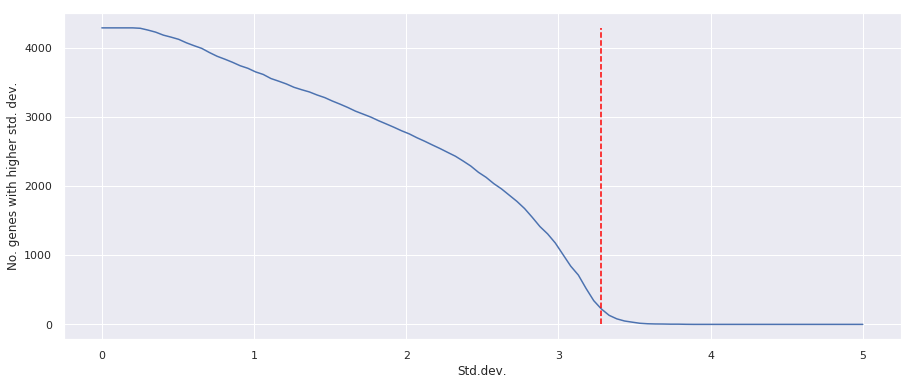

In [16]:
sns.set()
plt.figure(figsize=(15,6))
plt.plot(np.linspace(0,5,100), stdscores)
plt.plot([np.linspace(0,5,100)[65],np.linspace(0,5,100)[65]], [0,stdscores[0]], c = 'red', linestyle='--')
plt.ylabel('No. genes with higher std. dev.')
plt.xlabel('Std.dev.')
plt.show()

In [15]:
genemask = []
for i in range(D):
    if np.std(data[:,i])>np.linspace(0,5,100)[70]:
        genemask.append(True)
    else:
        genemask.append(False)
genemask = np.array(genemask)
print('Using genes with std.dev. of higher than %s'%str(np.linspace(0,5,100)[70]))

Using genes with std.dev. of higher than 3.5353535353535355


In [16]:
cropped_data = data[:,genemask]

In [17]:
N,D = np.shape(cropped_data)
print((N,D))

(1654, 16)


### Some examples of distributions of genes

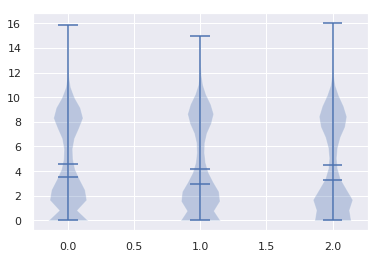

In [11]:
plotdata = [np.concatenate(cropped_data[labels==i,:]) for i in range(len(set(labels)))]
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

As the above plot demonstrates, this data is transformed already (by use of 'Combat' in R)

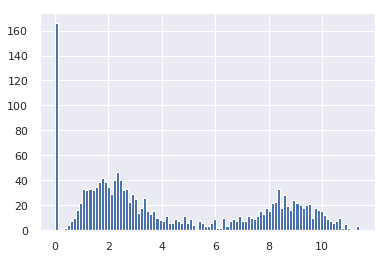

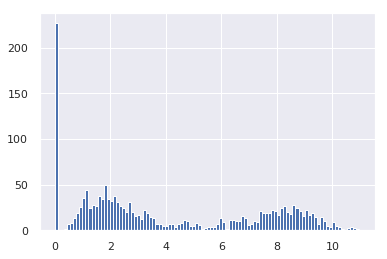

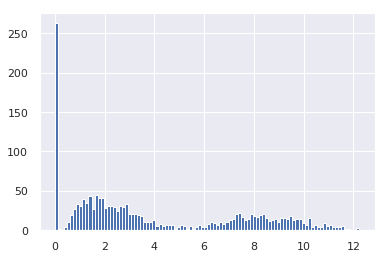

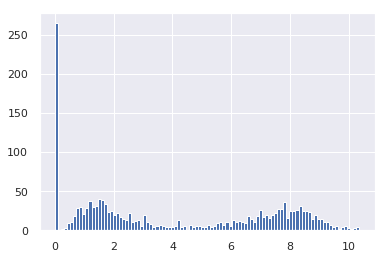

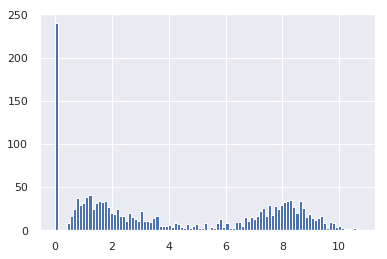

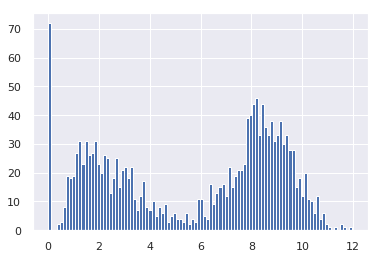

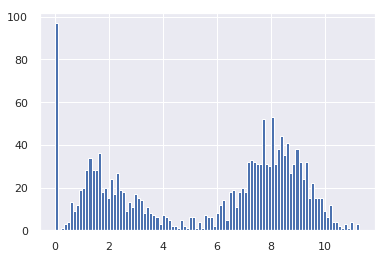

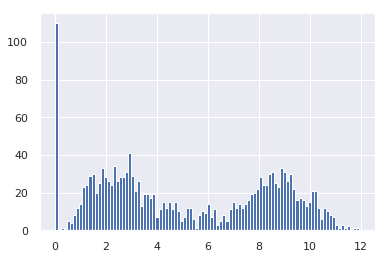

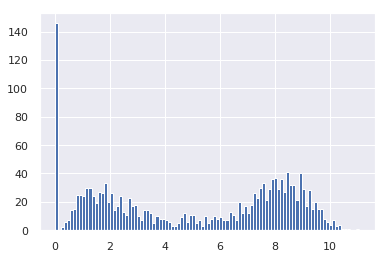

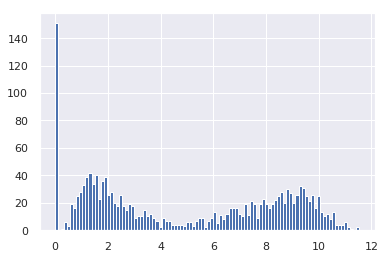

In [16]:
sns.set()
genes = np.random.choice(list(range(D)), p= np.std(cropped_data,axis=0)/sum(np.std(cropped_data,axis=0)), size=10, replace=False)
for i in range(10):
    plt.hist(cropped_data[:,genes[i]], bins=100)
    plt.show()

### Loading/Saving preprocessed data

In [18]:
# with open('nestorowa_prep.pkl', 'wb') as f:
#     pickle.dump([cropped_data, labels], f)

In [3]:
cropped_data, labels = pickle.load(open('nestorowa_prep.pkl', 'rb'))
N,D = np.shape(cropped_data)
print((N,D))

(1654, 222)


### Number of clusters is estimated very high, found clusters are not representative of genetype

In [7]:
est_k(cropped_data, k_max = 25, verbose=False, method='bic', refs=3)

25  clusters according to AIC,  21  clusters according to BIC.


(21, {'mu': array([[ 5.44144311,  2.97896896,  4.88328089, ...,  8.38033878,
           3.89455976,  6.37228401],
         [ 3.39686242,  8.39571733,  1.13825489, ...,  2.47907134,
           1.99352331,  6.64166856],
         [ 3.33374014,  2.10420478,  7.11399713, ...,  9.10660385,
           4.62508041,  6.21802422],
         ...,
         [ 3.30646878,  1.83044792,  4.05437874, ...,  7.6376852 ,
           3.97735257,  5.62133293],
         [ 3.92432587,  1.80335478,  2.5239075 , ...,  6.0275705 ,
          10.37256921,  6.41176623],
         [ 3.34413523,  2.47127691,  3.30884375, ...,  6.37291386,
           8.49870454,  9.29145775]]),
  'theta': [0.04353083434099154,
   0.05501813784764208,
   0.07799274486094317,
   0.02962515114873035,
   0.04232164449818621,
   0.06771463119709795,
   0.03204353083434099,
   0.1033857315598549,
   0.026602176541717048,
   0.07376058041112454,
   0.0471584038694075,
   0.036275695284159616,
   0.03385731559854897,
   0.034461910519951636,
   0

### No clear classes observed

In [9]:
n_test = 3
labels_test = KMeans(n_test).fit(data).labels_

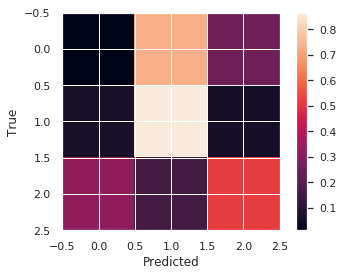

In [12]:
res = np.zeros((3,n_test))
for r in range(3):
    for t in range(n_test):
        res[r,t] = sum(labels[labels_test==t]==r)
    res[r,:] = res[r,:]/sum(res[r,:])
sns.set()
plt.imshow(res, label='Percentage samples')
plt.colorbar()
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [11]:
adjusted_rand_score(labels, labels_test)

0.19224414240436843

## Analysis

Model loaded succesfully from cache.
Model loaded succesfully from cache.
Latent data on top level:


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Estimated number of clusters (level 0):  2


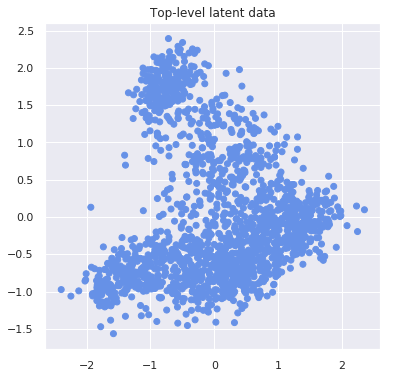

level  1 :
Cluster  1  contains  2  subclusters


RuntimeError: Initialization failed.

In [4]:
model = hierarchical_model()
latent, cats_per_lvl, probs = model.fit(cropped_data, max_depth=2)

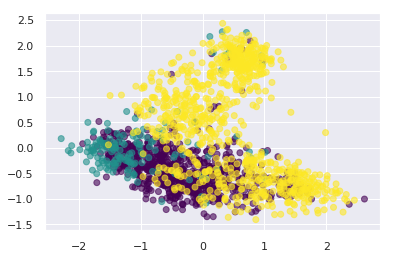

In [80]:
plt.scatter(latent[0][0],latent[0][1], c =labels, alpha=0.6, cmap='viridis')
plt.show()

In [93]:
kmns = KMeans(4).fit(cropped_data)